<a href="https://colab.research.google.com/github/tomik062/AI_Project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

extract data from github and merge together

In [16]:
import requests
import os
import importlib.util
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the GitHub details
def init_process():
  repo_owner = 'tomik062'
  repo_name = 'AI_Project'
  file_path = 'extract_data.py'
  url = f'https://raw.githubusercontent.com/{repo_owner}/{repo_name}/main/{file_path}'

  # Directory to save the downloaded file
  download_dir = 'data_extraction_code'
  if not os.path.exists(download_dir):
      os.makedirs(download_dir)

  local_file_path = os.path.join(download_dir, file_path)

  # Download the file
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  with open(local_file_path, 'wb') as f:
      f.write(response.content)

  print(f"Downloaded {file_path} to {local_file_path}")

  # Import the function from the downloaded file
  spec = importlib.util.spec_from_file_location("extract_data_module", local_file_path)
  module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(module)

  # Call the extract_data function and print the output
  return module.extract_data()

In [15]:
def calc_features_year(data,year):
    feature_map = {
        'urbanization': 0,
        'avg birth age': 1,
        'happiness': 2,
        'female labor participation': 3,
        'health expenditure': 4,
        'physicians per capita': 5,
        'GNI PPP': 6,
        'christians': 7,
        'muslims': 8,
        'no religion': 9,
        'buddhists': 10,
        'hindus': 11,
        'jews': 12,
        'other religion': 13,
        'in Asia-Pacific':14,
        'in Europe':15,
        'in Latin America-Caribbean':16,
        'in Middle East-North Africa':17,
        'in North America':18,
        'in Sub-Saharan Africa':19,
        'education man': 20,
        'education women': 21,
        'hdi': 22,
        'gii': 23,
        'avg marriage age women': 24,
        'avg marriage age men': 25,
        'maternity leave index': 26,
        'work hours men': 27,
        'work hours women': 28,
        'abortions': 29,
        'social media users': 30
    }
    countries = sorted(list(set([key[0] for key in data.keys()])))
    df = pd.DataFrame(index=countries, columns=feature_map.keys())
    target=[]
    # Populate the DataFrame
    for country in countries:
        key = (country, year)
        if key in data:
            features = data[key][1]
            target.append(data[key][0])
            for feature_name, feature_index in feature_map.items():
                if feature_index < len(features):
                  df.loc[country, feature_name] = features[feature_index]
                  if str(features[feature_index]) =='nan':
                    df.loc[country, feature_name]=handle_missing_values(data,feature_index,country,year)
    return df,target



def handle_missing_values(data, feature_index, country, year):
    # try taking the value from the last 3 years
    for i in range(1, 4):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and str(past_data[feature_index])!='nan':
                return past_data[feature_index]

    # otherwise if missing last 3 years, linearly extrapulate from last decade
    recent_years_data = []
    for i in range(10,0,-1):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and not pd.isna(past_data[feature_index]):
                 recent_years_data.append((past_year, past_data[feature_index]))

    if len(recent_years_data) >= 2:
        years = [item[0] for item in recent_years_data]
        values = [item[1] for item in recent_years_data]
        # Linear extrapolation using linear regression with polyfit
        try:
            m, c = np.polyfit(years, values, 1)
            extrapolated_value = m * year + c
            return extrapolated_value
        except np.linalg.LinAlgError:
            # Handle cases where polyfit fails (e.g., all years are the same)
            return values[-1] # Return the last known value
    elif len(recent_years_data) == 1:
         # If only one data point in the last 10 years, use that value
         return recent_years_data[0][1]

    # If still missing after checking last 10 years, return NaN
    return np.nan

In [10]:
def find_missing_features(df_features):

  # Identify countries with and without NaN values
  countries_with_nan = df_features[df_features.isnull().any(axis=1)].index.tolist()
  countries_without_nan = df_features.dropna().index.tolist()
  countries_with_one_nan = df_features[df_features.isnull().sum(axis=1) == 1].index.tolist()

  # Print the results
  print("Countries with NaN values in their features:")
  print(countries_with_nan)
  print("\nCountries without NaN values in their features:")
  print(countries_without_nan)
  print("\nCountries with exactly one NaN value in their features:")
  print(countries_with_one_nan)

  print(f"\nNumber of countries with NaN values: {len(countries_with_nan)}")
  print(f"Number of countries without NaN values: {len(countries_without_nan)}")
  print(f"Number of countries with exactly one NaN value: {len(countries_with_one_nan)}")

  # Group countries by their single missing feature
  missing_features_grouped = {}
  if countries_with_one_nan:
      for country in countries_with_one_nan:
          missing_feature_name = df_features.loc[country].isnull().idxmax()
          if missing_feature_name not in missing_features_grouped:
              missing_features_grouped[missing_feature_name] = []
          missing_features_grouped[missing_feature_name].append(country)

      # Print countries grouped by missing feature
      print("\nMissing feature for countries with exactly one NaN:")
      for feature, countries in missing_features_grouped.items():
          print(f"  Missing feature is '{feature}':")
          print(f"    Countries: {', '.join(countries)}")

process 2023 data:
add some missing data, split to train and test and normalize

In [17]:
def process_2023_data(data_output):
    df_features, target = calc_features_year(data_output, 2023)
    missing_values_to_fill = {
        'abortions': {
            'Cyprus': 7,'Ireland': 6.7,'Malaysia': 11,
            'Mauritania': 42,'Malta': 3,'Morocco': 25
        },
        'female labor participation': {
            'China': 59.6,'Gabon': 41.7,'Haiti': 60
        },
        'maternity leave index': {
            'Albania': 23.23,'Bosnia and Herzegovina': 52.14,
            'Kazakhstan': 18,'Georgia': 7.59,'Kyrgyz Republic': 18,
            'Moldova': 18,'Angola': 13,'Armenia': 20,
            'Azerbaijan': 18,'Malawi': 12.86,'Bhutan': 8,
            'Tanzania': 12,'Tajikistan': 20,'North Macedonia': 39,
            'Liberia': 12.86,'Suriname': 0,'Uzbekistan': 18
        }
    }

    # Fill in missing values using the dictionary
    for feature, country_values in missing_values_to_fill.items():
        for country, value in country_values.items():
            if country in df_features.index:
                df_features.loc[country, feature] = value


    # Create a DataFrame for the target variable
    y = pd.Series(target, index=df_features.index, name='target')

    # Combine features and target into a single DataFrame for easier NaN handling
    combined_df = pd.concat([df_features, y], axis=1)

    # Remove rows with NaN values
    combined_df_cleaned = combined_df.dropna()

    # Separate features and target again
    X = combined_df_cleaned.drop('target', axis=1)
    y = combined_df_cleaned['target']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Z-scale 'physicians per capita' and 'health expenditure'
    scaler_physicians = StandardScaler()
    X_train['physicians per capita_scaled'] = scaler_physicians.fit_transform(X_train[['physicians per capita']])
    X_test['physicians per capita_scaled'] = scaler_physicians.transform(X_test[['physicians per capita']])

    scaler_health = StandardScaler()
    X_train['health expenditure_scaled'] = scaler_health.fit_transform(X_train[['health expenditure']])
    X_test['health expenditure_scaled'] = scaler_health.transform(X_test[['health expenditure']])

    # Create 'healthcare index score'
    X_train['healthcare index score'] = X_train['physicians per capita_scaled'] + X_train['health expenditure_scaled']
    X_test['healthcare index score'] = X_test['physicians per capita_scaled'] + X_test['health expenditure_scaled']

    # Remove original 'physicians per capita' and 'health expenditure' features
    X_train = X_train.drop(['physicians per capita', 'health expenditure', 'physicians per capita_scaled', 'health expenditure_scaled'], axis=1)
    X_test = X_test.drop(['physicians per capita', 'health expenditure', 'physicians per capita_scaled', 'health expenditure_scaled'], axis=1)
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = process_2023_data(init_process())

Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high_education_female.xlsx to data/high_education_female.xlsx
Downloaded high_educati

In [20]:
print (X_train)

         urbanization avg birth age happiness female labor participation  \
Mali        44.585857        28.859     4.232                     41.852   
Georgia       60.1143        28.501     5.185                     55.004   
Albania     61.257164        29.132     5.304                  59.350071   
Benin         50.1711        29.079     4.377                     74.346   
Ethiopia    22.341082        29.079     3.861                     57.604   
...               ...           ...       ...                        ...   
Lesotho     36.038677         27.91     3.186                  43.358333   
Senegal     50.530487         29.92     4.969                     38.406   
Bolivia      71.37134        28.144     5.784                     72.587   
Niger       22.460955        29.085     4.556                     73.288   
Portugal     67.48844        31.727      6.03                     55.562   

          GNI PPP christians    muslims no religion buddhists    hindus  ...  \
Mali   

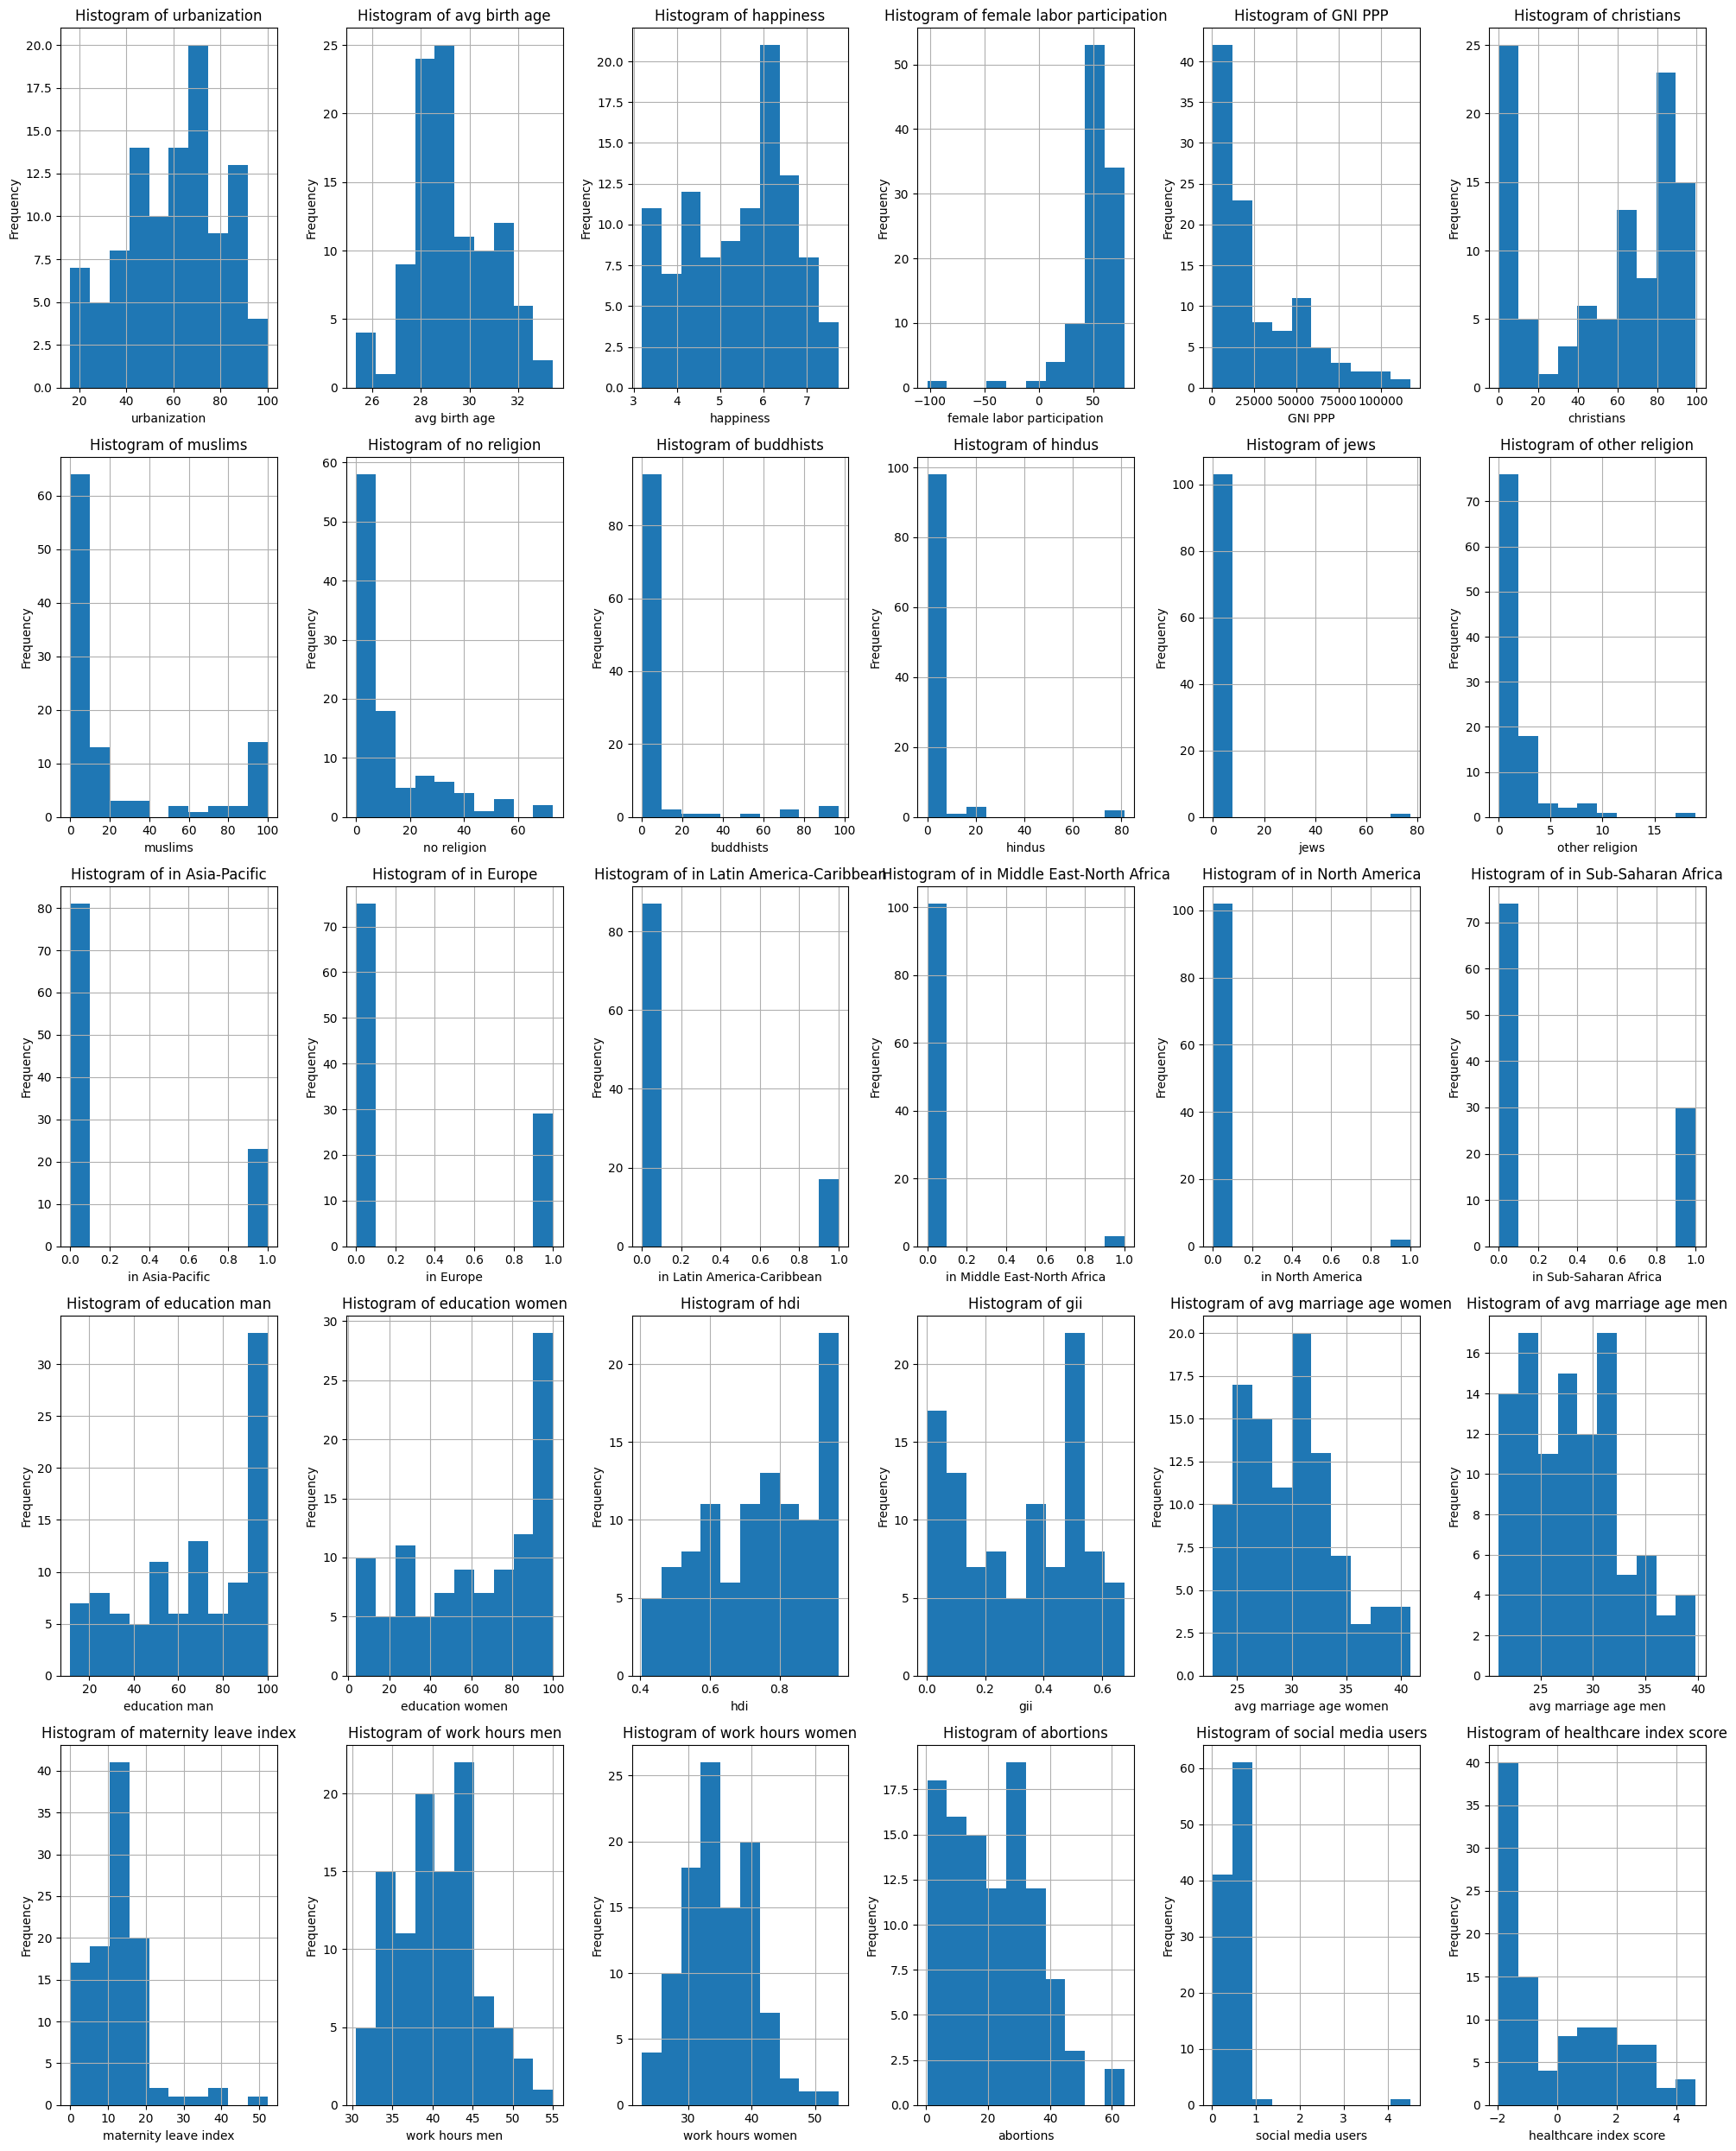

In [21]:
import matplotlib.pyplot as plt
import math

# Get the list of columns
columns = X_train.columns

# Calculate the number of rows needed
n_cols = 6
n_rows = math.ceil(len(columns) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Plot histograms for all features
for i, column in enumerate(columns):
    axes[i].hist(X_train[column], bins=10)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()